# Model

In [1]:
from numpy import newaxis
from scipy import stats
from seaborn import set as sns_set
from seaborn import FacetGrid, heatmap
from sklearn import grid_search
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

from context import *
from util.dfmgmt import initSet, wrangle, dropOutliers
from util.polarize import *

In [2]:
sns_set(style="whitegrid", font_scale=1)
%matplotlib inline

target = 'charted'  # main feature to be predicted

bestParam = float(getBestParam('best_param_no_time.txt'))

In [3]:
df = initSet()
df = df[df['decade'] != 2010]

In [4]:
# Check head
df.head()

,year,decade,unique_words,density,unique_words_raw,density_raw,nouns,verbs,adjectives,syllables,most_used_term,most_used_freq,explicit,total_curses,reading_score,sentiment,charted
0,1961,1960,36,72,65,158,34,30,10,70,rose,7,0,0,2.367848,0.9901,0
1,1961,1960,45,91,74,197,45,37,19,81,name,6,0,0,2.771777,0.9712,1
2,1961,1960,54,103,88,223,45,48,17,98,babi,10,0,0,3.885650,0.9974,1
3,1961,1960,42,148,66,263,81,61,36,76,love,24,0,0,2.889886,0.9993,1
4,1961,1960,28,131,60,354,56,77,5,57,come,38,0,0,2.940000,0.9812,1


### Build model without time

In [5]:
df['sentiment_polarity'] = df.apply(sentiment, axis=1)  # classify sentiment score

In [6]:
# Drop both year and decade
dropList = ['most_used_term', 'reading_score', 'sentiment',
            'year', 'decade']
removeList = ['charted']

df_new, features = wrangle(df, dropList, removeList, True)
df_new.head()

,unique_words,density,unique_words_raw,density_raw,nouns,verbs,adjectives,syllables,most_used_freq,explicit,total_curses,charted,sentiment_polarity
0,36,72,65,158,34,30,10,70,7,0,0,0,1
1,45,91,74,197,45,37,19,81,6,0,0,1,1
2,54,103,88,223,45,48,17,98,10,0,0,1,1
3,42,148,66,263,81,61,36,76,24,0,0,1,1
4,28,131,60,354,56,77,5,57,38,0,0,1,1


In [7]:
from sklearn import linear_model

# set X and y and build model
X = df_new[features]
y = df_new[target]

# Create separate training and test sets with 60/40 train/test split
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=1000
)

# train model with classifier and parameter determined best
clf = linear_model.LogisticRegression(C=bestParam)
clf.fit(X_train, y_train)

LogisticRegression(C=0.03125, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Accuracy of training set: 0.724
Accuracy of test set: 0.705


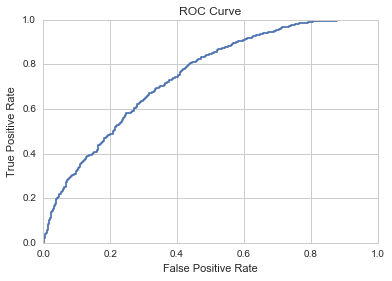

ROC AUC: 0.746


In [8]:
# Evaluate accuracy of model on test set
print "Accuracy of training set: %0.3f" % clf.score(X_train, y_train)
print "Accuracy of test set: %0.3f" % clf.score(X_test, y_test)

# Plot ROC curve and get AUC score
y_pred_proba = clf.predict_proba(X_test)[:,1]

# Determine the false positive and true positive rates
fpr, tpr, t = roc_curve(y_test, y_pred_proba)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# Get ROC AUC score
print 'ROC AUC: %0.3f' % roc_auc_score(y_test, y_pred_proba)

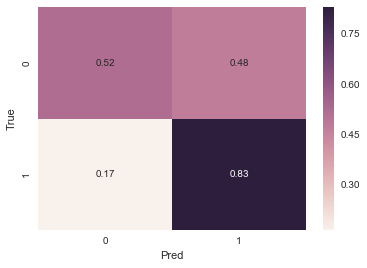

In [9]:
# Get confusion matrix on test set
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, newaxis]

ax = plt.axes()
heatmap(cm_normalized, annot=True)
ax.set_ylabel('True')
ax.set_xlabel('Pred')
plt.show()

In [10]:
df_test = X_test
df_test['predict'] = y_pred
df_test[target] = y_test

/home/sabbir/anaconda2/envs/venv/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/sabbir/anaconda2/envs/venv/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [11]:
df_test.tail(10)

,unique_words,density,unique_words_raw,density_raw,nouns,verbs,adjectives,syllables,most_used_freq,explicit,total_curses,sentiment_polarity,predict,charted
2244,68,109,111,236,43,56,19,122,8,0,0,1,1,0
1263,57,184,85,302,53,63,74,97,46,0,0,1,1,1
3256,95,274,104,300,168,19,74,153,23,0,0,-1,0,0
936,40,125,68,267,51,67,13,68,8,0,0,1,1,1
2958,64,135,101,290,37,111,13,105,13,0,0,1,1,0
3025,75,110,109,216,54,25,26,120,4,0,0,1,0,0
3815,27,42,49,116,26,14,6,52,4,1,4,-1,0,0
3532,49,55,76,118,26,34,5,86,2,0,0,-1,0,0
2094,45,52,76,134,36,23,8,82,3,0,0,-1,0,0
1825,67,134,106,317,60,74,27,121,8,0,0,-1,0,0


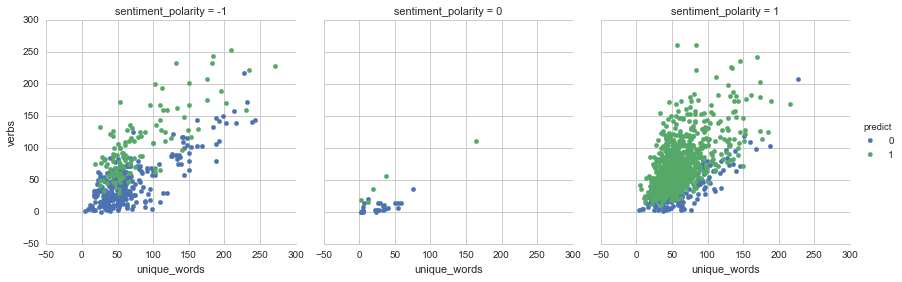

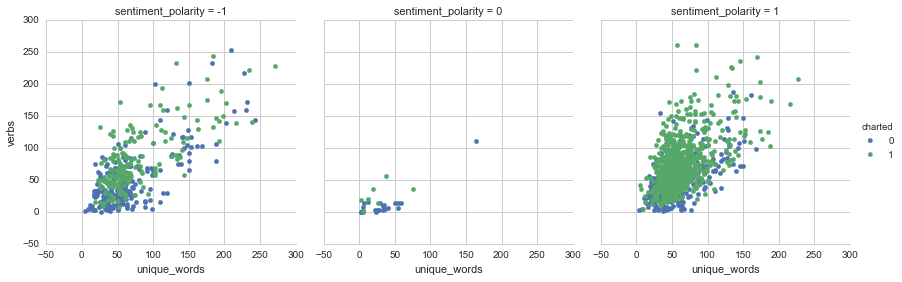

In [12]:
def qqplot(x, y, **kwargs):
    _, xr = stats.probplot(x, fit=False)
    _, yr = stats.probplot(y, fit=False)
    plt.scatter(xr, yr, **kwargs)

plt.figure(figsize=(12,10))
g = FacetGrid(df_test, hue='predict', col='sentiment_polarity', size=4)
g.map(plt.scatter, 'unique_words', 'verbs')
g.add_legend()
plt.show()

plt.figure(figsize=(12,10))
x = FacetGrid(df_test, hue='charted', col='sentiment_polarity', size=4)
x.map(plt.scatter, 'unique_words', 'verbs')
x.add_legend()
plt.show()